# Barclays Premier League Fantasy Football Data Analysis

## Introduction

I've been really into BPL Fantasy Football this season and have been building a fantasy team since the start of the season last year. 

I'm not very good at picking the right squad based on my instincts, so my basic goal is to use the data from the present and past weeks to determine the best picks for the upcoming week.

## How Fantasy Football Works

I play Fantasy Football off the <a href='http://fantasy.premierleague.com'> official BPL Fantasy site</a>. For the uninitiated, Fantasy Football is an online game where users pick a squad of 15 real-life football players from a league. In this case, I'm playing the BPL, which is the English top division. Points are scored and collated depending on a player's actions in the actual game. The aim of the game is to amass the highest number of points each game week. The rules are <a href='http://fantasy.premierleague.com/rules/'> here</a>. Friends tend to form mini-competitions to see who's better at picking the best squad week after week. At the end of the season, the winner of their league with the higest points gets the honour of having the best fantasy football instincts (although there's usually money involved in mini-leagues amongst friends). There's a budget allocated to each user so you can't always choose the best player. Players get transferred in and out of teams weekly, so there's an entire transfer market 

## Fantasy Football Data

Data is available from an API from the official site on players' basic information, team information, fixture information and performance stats. Each player's performance is aggregated every gameweek to give an overall view of the players' performance. There are nested data sets on each player's weekly performance history, as well as performance in past seasons.    

There are 549 players in the fantasy football database. I'll import some basic data on them for a start. 

In [146]:
import requests as rq

In [155]:
## Taking a look at one player's data 

r25 = rq.get('http://fantasy.premierleague.com/web/api/elements/3')
d25 = r25.json()

## The data fields available for each player. 

print d25.keys()
print len(d25.keys())

[u'transfers_out', u'yellow_cards', u'code', u'event_total', u'goals_conceded', u'photo', u'red_cards', u'saves', u'ep_this', u'value_form', u'next_fixture', u'team_id', u'goals_scored', u'loans_in', u'web_name', u'value_season', u'team_name', u'cost_change_start_fall', u'team_code', u'fixtures', u'special', u'first_name', u'transfers_out_event', u'chance_of_playing_next_round', u'cost_change_start', u'cost_change_event_fall', u'event_explain', u'type_name', u'bps', u'id', u'bonus', u'season_history', u'total_points', u'penalties_missed', u'status', u'form', u'own_goals', u'loaned_in', u'current_fixture', u'now_cost', u'fixture_history', u'clean_sheets', u'assists', u'selected_by_percent', u'transfers_in', u'loans_out', u'news', u'ea_index', u'penalties_saved', u'dreamteam_count', u'in_dreamteam', u'points_per_game', u'minutes', u'loaned_out', u'transfers_in_event', u'selected_by', u'element_type', u'ep_next', u'team', u'chance_of_playing_this_round', u'event_points', u'second_name', u

### Diving deeper into Player Data 

There are a total of 63 data attributes for any single player. Each player has a unique player id, and data is updated once every <i>gameweek</i>. That is to say, a full round of fixtures played amongst 20 teams. [Note: Fixtures sometimes get postponed from one gameweek to another, so that might be a complication for the data set.] 

In essence, the gameweek view reflects the player's (a) cumulative performance up to that gameweek and (b) the player's performance in that particular gameweek. 

Above that, there are some <b>nested</b> attributes that give us a whole lot more information. For instance, for each player, the attribute 'fixture_history' returns the players performance down to the individual fixtures of the current season played up to the current gameweek. 'season_history' returns the players' cumulative performance over the past few seasons (if they are available). 

This presents a whole different order of magnitude of information, so I'll be focusing on gameweek level data for a start. 

The Fantasy League API doesn't really have a guide, so I'm going to give a brief overview of the variables I'll be using for a start:

- <b>Personal Attributes</b>
    - Player ID - Unique Identifier
    - First Name, Last name
    - Position, ie. Goalkeeper, Midfielder
- <b>Team Attributes</b>
    - Team name, Team ID
- <b>Real Life Performance Attributes</b> (measured up to current gameweek)
    - Total Goals scored
    - Assists
    - Goals Conceded
    - Total minutes played
- <b>Fantasy Performance Attributes</b> 
    - Total points scored
    - Points per game
    - Total Bonus points
    - Number of points scored in the most recent gameweek
    - Number of Bonus points scored in the most recent gameweek

[<i>These characterise the fantasy points, measured up to current gameweek, that each player has scored according to the fantasy system, and not in "real life". Bonus points are tallied in a separate system, where more "minor actions" in a game, such as a shot on target, a tackle or a clearance can be tallied. These do not directly contribute towards fantasy points.</i>]
 
- <b> Transfer Market Attributes</b>
    - Total Transfers In
    - Total Transfers Out
- <b> Injury Attributes </b>
    - % Chance of playing in this round
    - % Chance of playing in the next round

With that, I'm going to extract the fantasy points as the outcome variable and 21 features for 549 players. 

In [164]:
required_fields=['id','first_name','second_name','team_name','team_id','type_name','event_points','event_total','assists','goals_scored','goals_conceded','now_cost','bonus','bps','dreamteam_count','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form','points_per_game','next_fixture','total_points']
print (len(required_fields))

22


In [156]:
data=[]
print type(data)
for i in range(1,550):
    r = rq.get('http://fantasy.premierleague.com/web/api/elements/%d' %(i))
    d = r.json()
    p_data = [d[required_fields[j]] for j in range(len(required_fields))]
    data.append(p_data)
    

<type 'list'>


In [125]:
# Convert to data frame.. 

import csv 
import pandas as pd
df = pd.DataFrame(data,columns=required_fields)

In [159]:
## I'm going to export the data to a csv so I don't have to keep pinging the API. 

df.to_csv('Fantasy Gameweek 25.csv', encoding='utf')

In [192]:
## Top 10 players in Fantasy Football

df.sort_values(by='total_points',ascending=False).head(10)

,id,first_name,second_name,team_name,team_id,type_name,event_points,event_total,assists,goals_scored,...,bonus,bps,dreamteam_count,chance_of_playing_next_round,chance_of_playing_this_round,minutes,form,points_per_game,next_fixture,total_points
162,163,Riyad,Mahrez,Leicester,7,Midfielder,14,14,10,14,...,32,609,10,100,100,1959,6.0,7.6,Arsenal (A),183
169,170,Jamie,Vardy,Leicester,7,Forward,2,2,5,18,...,24,619,3,100,100,2178,5.6,6.2,Arsenal (A),156
148,149,Romelu,Lukaku,Everton,6,Forward,9,9,5,16,...,25,531,7,100,75,2151,3.2,6.0,West Brom (H),151
441,442,Odion,Ighalo,Watford,18,Forward,2,2,6,15,...,25,493,7,100,100,2128,4.0,6.0,Crystal Palace (A),149
14,15,Mesut,Özil,Arsenal,1,Midfielder,10,10,16,4,...,25,609,3,100,100,1989,3.4,6.4,Leicester (H),148
137,138,Ross,Barkley,Everton,6,Midfielder,3,3,8,8,...,14,518,4,NaN,NaN,2182,5.2,5.3,West Brom (H),133
349,350,Harry,Kane,Spurs,14,Forward,2,2,2,15,...,21,464,5,NaN,NaN,2204,6.4,5.2,Man City (A),131
2,3,Petr,Cech,Arsenal,1,Goalkeeper,10,10,0,0,...,12,542,1,NaN,NaN,2250,6.6,4.9,Leicester (H),123
496,497,Georginio,Wijnaldum,Newcastle,11,Midfielder,3,3,4,9,...,11,494,3,NaN,NaN,2207,5.6,4.9,Chelsea (A),122
415,416,André,Ayew,Swansea,17,Midfielder,2,2,4,8,...,16,370,4,100,100,2081,6.2,5.0,Southampton (H),119


In [198]:
## Just some cleaning to make sure the strings are converted to floating numbers.

df.form = df.form.astype(float)
df.points_per_game = df.points_per_game.astype(float)

In [199]:
## Summary Statistics

df.describe()

,id,team_id,event_points,event_total,assists,goals_scored,goals_conceded,now_cost,bonus,bps,dreamteam_count,chance_of_playing_next_round,chance_of_playing_this_round,minutes,form,points_per_game,total_points
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,428.000000,427.000000,549.000000,549.000000,549.000000,549.000000
mean,275.000000,10.462659,1.378871,1.378871,0.965392,1.056466,12.382514,51.027322,2.708561,168.085610,0.471767,63.726636,62.704918,854.652095,1.401093,2.153188,35.060109
std,158.626921,5.781055,2.549937,2.549937,1.794325,2.283410,11.742187,12.313913,4.337363,162.563379,0.995256,46.887453,47.234576,770.184671,1.842740,1.576855,34.402964
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,138.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,43.000000,0.000000,7.000000,0.000000,0.000000,0.000000,57.000000,0.000000,1.000000,2.000000
50%,275.000000,10.000000,0.000000,0.000000,0.000000,0.000000,10.000000,47.000000,0.000000,122.000000,0.000000,100.000000,100.000000,729.000000,0.600000,2.100000,27.000000
75%,412.000000,15.000000,2.000000,2.000000,1.000000,1.000000,21.000000,54.000000,4.000000,294.000000,1.000000,100.000000,100.000000,1500.000000,2.400000,3.200000,58.000000
max,549.000000,20.000000,16.000000,16.000000,16.000000,18.000000,48.000000,136.000000,32.000000,619.000000,10.000000,100.000000,100.000000,2250.000000,9.600000,7.600000,183.000000


In [169]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np

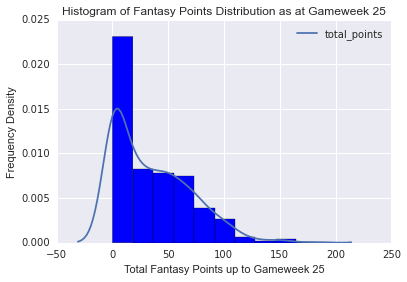

In [180]:
# One response variable here is the amount of fantasy points scored. Let's take a look at the distribution

plt.hist(df.total_points,color='blue',normed=True)
plt.title("Histogram of Fantasy Points Distribution as at Gameweek 25")
plt.ylabel("Frequency Density")
plt.xlabel("Total Fantasy Points up to Gameweek 25")
sns.kdeplot(df.total_points)

Data is highly skewed to the left. About 20% of players score 10 points and below. These are probably guys from the reserve team, long term injuries etc. 

Let's look at how the features correlate with our response variable

In [200]:
df.corr()['total_points']

id                             -0.066346
team_id                        -0.027877
event_points                    0.512975
event_total                     0.512975
assists                         0.644498
goals_scored                    0.647920
goals_conceded                  0.755711
now_cost                        0.477597
bonus                           0.842220
bps                             0.939425
dreamteam_count                 0.697499
chance_of_playing_next_round    0.416410
chance_of_playing_this_round    0.425193
minutes                         0.905743
form                            0.745225
points_per_game                 0.819705
total_points                    1.000000
Name: total_points, dtype: float64

Pretty strong associations all around, likely >0 for most features. Highest correlation between 'bps' variable and fantasy points scored. This is expected because 'bps' is kind of like a captures fantasy point scoring actions and then some.

Going back to the analytical objective of predicting the highest fantasy points scorer, it would be instructive to consider the outcome variable as the number of points scored in the current week.

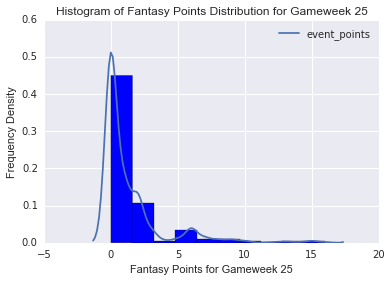

In [183]:
# Let's look at the distribution again..

plt.hist(df.event_points,color='blue',normed=True)
plt.title("Histogram of Fantasy Points Distribution for Gameweek 25")
plt.ylabel("Frequency Density")
plt.xlabel("Fantasy Points for Gameweek 25")
sns.kdeplot(df.event_points)

Expectedly, this is even more skewed because any given team is allowed to play 11 players and field three substitutes, leaving only a maximum of 14 out of a typical squad of 28 that can score points. 

In [201]:
df.corr()['event_points']

id                             -0.114676
team_id                        -0.144243
event_points                    1.000000
event_total                     1.000000
assists                         0.331906
goals_scored                    0.328215
goals_conceded                  0.330107
now_cost                        0.237014
bonus                           0.457131
bps                             0.470325
dreamteam_count                 0.421987
chance_of_playing_next_round    0.407069
chance_of_playing_this_round    0.415642
minutes                         0.423960
form                            0.710053
points_per_game                 0.512714
total_points                    0.512975
Name: event_points, dtype: float64

What stands out for me here is that form seems like more highly correlated that the cumulative points, or points per game. This means that the a player's performance in the past few games is likely to be a better predictor of his current performance than his performance in the overall season.

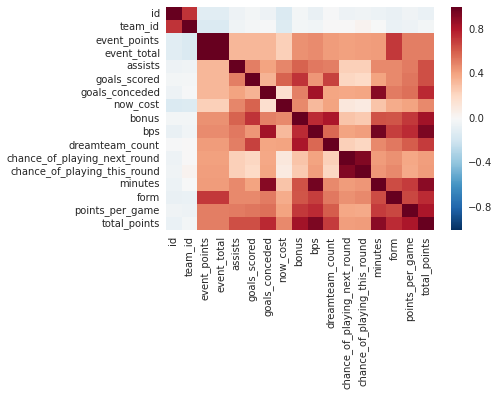

In [202]:
## Just do a heatmap to see if there are any strong intra-feature correlations...

sns.heatmap(df.corr())

This preliminary analysis leads me to the conclusion that I should be digging a bit more into the player's form to uncover more features to predict his next gameweek's performance. I'll be working extracting information from the nested datasets on player fixture history in the next week. 

In [212]:
## In the meantime, a simple linear regression model to start with 
import statsmodels.formula.api as smf
lm= smf.ols(formula='event_points ~ form + total_points + minutes + bps + bonus + now_cost',data=df)

results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           event_points   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     94.13
Date:                Fri, 12 Feb 2016   Prob (F-statistic):           9.22e-81
Time:                        00:00:26   Log-Likelihood:                -1096.4
No. Observations:                 549   AIC:                             2207.
Df Residuals:                     542   BIC:                             2237.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.6177      0.384      1.610      0.108        -0.136     1.372
form             1.0085      0.063     16.008      0.000         0.885     1.132
total_points     0.0052      0.011      0.495      0.621        -0.016     0.026
minutes         -0.0007      0.000     -1.437      0.151        -0.002     0.000
bps              0.0013      0.002      0.551      0.582        -0.003     0.006
bonus            0.0181      0.041      0.437      0.662        -0.063     0.099
now_cost        -0.0106      0.008     -1.350      0.178        -0.026     0.005
==============================================================================
Omnibus:                      264.212   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2583.306
Skew:                           1.873   Prob(JB):                         0.00
Kurtosis:                      12.945   Cond. No.                     5.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No surprises from here so far, but pretty high explanatory power for the initial model. 